This code is going to be able to take a DAG in networkX and output a new dag that acts as a state machine for moving nondeterminately through the original DAG.

First Imports

In [2]:
# %pip install networkx pandas matplotlib scipy more-itertools

import pandas as pd
import numpy as np
import networkx as nx

C:\Users\ethan\AppData\Local\Temp\ipykernel_24628\2056595195.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Next Ill make 2 example DAGs:

![DAG1](DAG1.png)
![DAG2](DAG2.png)

In [3]:
dag1 = nx.DiGraph()
dag1.add_edges_from([("A", "C"), ("A", "D"), ("B", "D"), ("C", "D")])
# nx.draw(dag1, with_labels = True)

dag2 = nx.DiGraph()
dag2.add_edges_from([("A", "B"),("A", "C"), ("B", "D"), ("C", "D")])
# nx.draw(dag2, with_labels = True)

# Implementation

Given a DAG $G(E,V)$, return a state machine $M$

Starting with a stack with the empty state $\emptyset$

While the stack is not empty:
1) Choose a state $S$ from the stack
2) Find all in-degree 0 nodes $N$ in the induced subgraph of $G$ by $V-S$
3) Find possible moves by $S \cup m   \forall {m \in \mathcal{P}(N) - \emptyset}$
4) Add edges to $M$ from $S$ to all moves fround in 4.


In [29]:
from itertools import chain, combinations
import time

def powerset(iterable, max=-1):
    
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

def stateToString(state):
    s = sorted(state)
    return str(s)

def makeStateMachine(dag, time_limit_sec=20):
    stime = time.time()
    iterations = 0
    timing=[[],[],[],[],0] #holds timing info for [whole iter, avail moves, move set, updateing graph, self loops(only 1 val)]
    newStates = []

    dag2 = nx.DiGraph()
    stateStack = [[]]
    
    while len(stateStack) > 0:
        t0 = time.time()
        
        #pick a state from stack
        s = stateStack.pop()
        
        
        #find all in-degree 0 nodes with state removed
        dagCopy = dag.copy()
        dagCopy.remove_nodes_from(s)
        degs = list(dagCopy.in_degree())
        moves = [x[0] for x in degs if x[1]==0]
        # moves = list(filter(lambda x: x!=-1, moves))
        t1 = time.time()
        
        #find power set of possible moves (not including no move)
        # was tuples, so convert to lists
        pSet = [list(x) for x in powerset(moves)]
        t2 = time.time()
        
        #for each move, append to current state, and add to stack
        for p in pSet:
            n = s.copy()
            n.extend(p)
            if(stateToString(n) not in dag2.nodes):
                dag2.add_edge(stateToString(s), stateToString(n))
                stateStack.append(n)
        
        
        t3 = time.time() #timing for whole iteration
        #timing code
        
        timing[0].append(t3-t0) #timing of whole iteration
        timing[1].append(t1-t0) #timing of finding avaialable classes
        timing[2].append(t2-t1) #timing of generating power set
        timing[3].append(t3-t2) #timing of updating graph
        
        
        iterations+=1
        if (time.time()-stime) > time_limit_sec:
            break
    
    t4=time.time()
    #include self edges
    dag2.add_edges_from([(n,n) for n in dag2.nodes])
    
    t5=time.time()
    
    timing[4] = t5-t4 #timing to add the self loops
    return dag2, timing, iterations

        
# stateMachine = makeStateMachine(dag1)
# nx.draw(stateMachine, with_labels=True)
    

# Validation of Code

### DAG 1
Expected:

![DAG1](DAG1.png)

Result:

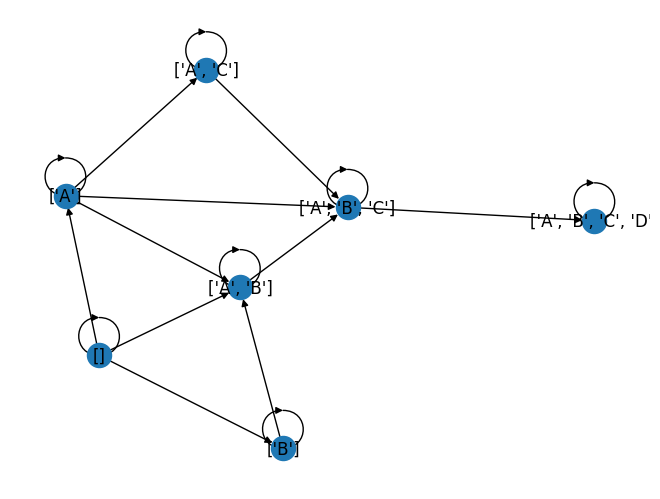

In [5]:
nx.draw(makeStateMachine(dag1), with_labels=True)

### DAG 2
Expected:

![DAG2](DAG2.png)

Result:

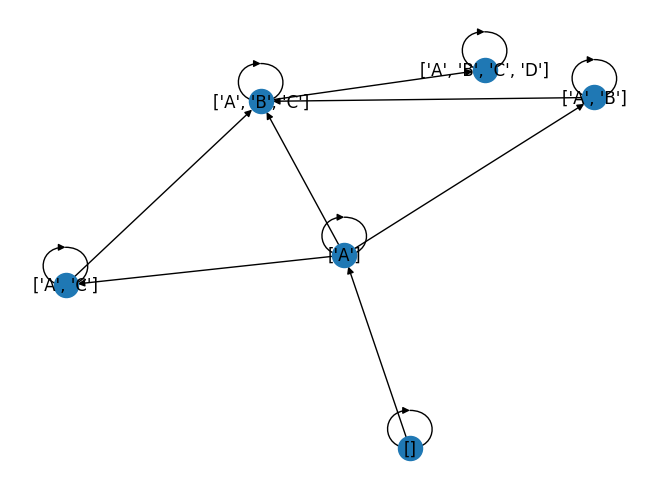

In [6]:
nx.draw(makeStateMachine(dag2), with_labels=True)

### DAG3
Expected:

![DAG3](DAG3.png)

Result:


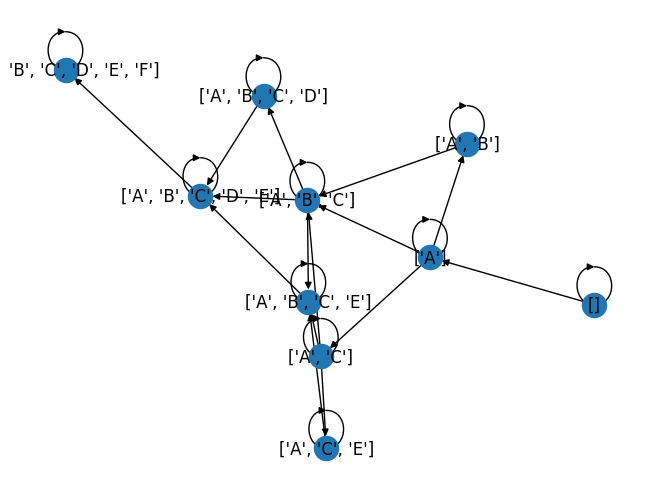

In [7]:
dag3=nx.DiGraph([("A","B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"), ("D", "F"), ("E", "F")])
nx.draw(makeStateMachine(dag3), with_labels=True)

# Applying the Method to the CS Core Prereq Graph

For now, I'm going to pull over the code from Alex's work into this notebook


I'll be doing some timing experiments!

In [36]:
import matplotlib as mpl

G = nx.DiGraph()

with open('prereqs2021.txt') as fp:
    lines = fp.readlines()

classes = set()
for line in lines:
    split = line.split(" ")
    classes.add(split[0].replace("\n", ""))
    classes.add(split[1].replace("\n", ""))

G.add_nodes_from(classes)

for line in lines:
    split = line.split(" ")
    G.add_edge(split[0].replace("\n", ""), split[1].replace("\n", ""))
    
    
    
#start problem, limiting the compute time for all iterations to 10 sec
GSM, timing, iters = makeStateMachine(G, time_limit_sec=10)

# nx.draw(GSM)
print(f'{len(GSM.nodes)} states found across {iters} iterations.')
print(f'Avg times for:')
totTime = sum(timing[0])/iters
print(f'Iteration: {totTime} sec')
print(f'Finding available Classes: {sum(timing[1])/iters} sec ({sum(timing[1])/iters / totTime *100}%)')
print(f'Finding possible moves: {sum(timing[2])/iters} sec ({sum(timing[2])/iters / totTime *100}%)')
print(f'Updating the Graph: {sum(timing[3])/iters} sec ({sum(timing[3])/iters / totTime *100}%)')
print("")
print(f'Time for adding self loops: {timing[4]} sec')

# nx.draw(GSM)

with open("SM.txt", "w") as fout:
    lines=list(GSM.nodes)
    lines.sort(key=len)
    for l in lines:
        fout.write(l+"\n")


428 states found across 428 iterations.
Avg times for:
Iteration: 0.00036604994925383094 sec
Finding available Classes: 0.0003426949554514662 sec (93.61972489001231%)
Finding possible moves: 4.626880182284061e-06 sec (1.2640024105222951%)
Updating the Graph: 1.872811362008068e-05 sec (5.116272699465394%)

Time for adding self loops: 0.0 sec
